<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/master/suicide_risk_prediction_exp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers 
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install datasets
!pip install torchinfo

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug 25 02:00:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

#nlp = spacy.load('en_core_web_sm')

from collections import defaultdict

from tqdm import tqdm # Runtime progress bar

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Variables

In [5]:
model_name = "suicide_risk_analysis_model"
target_map = {'low_risk': 0, 'high_risk':1}
idx2newidx = {0:0,1:1,2:1,3:1}
checkpoint ="roberta-base"
num_labels=2


In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/data/sr_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data/sr_test.csv')

In [7]:
train_df.label = train_df.label.map(idx2newidx)
test_df.label = test_df.label.map(idx2newidx)

In [8]:
train_df.to_csv('/content/drive/MyDrive/data/sr_binary_train.csv')
test_df.to_csv('/content/drive/MyDrive/data/sr_binary_test.csv')

### Hugging Face Creating Dataset Object

In [9]:
raw_datasets = load_dataset(
    'csv',
    data_files={'train':'/content/drive/MyDrive/data/sr_binary_train.csv',
                'test':'/content/drive/MyDrive/data/sr_binary_test.csv'}
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e2787133226a31ac/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'label', 'sent1', 'sent2', 'sent3'],
        num_rows: 386
    })
    test: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'label', 'sent1', 'sent2', 'sent3'],
        num_rows: 101
    })
})

In [ ]:
raw_datasets['train']['sent1'][0]

In [ ]:
raw_datasets['test']['sent1'][0]

### Tokenizer

In [13]:
from transformers import AutoTokenizer

In [14]:

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [15]:
tokenizer

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [16]:
#,batch['sent2']
def tokenize_fn(batch):
  return tokenizer(batch['sent1'],batch['sent2'], truncation=True, padding=True, max_length=512)

tokenized_dataset = raw_datasets.map(tokenize_fn, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
tokenized_dataset['train']['input_ids'][0][0:10]

[0, 620, 5858, 4157, 2123, 11360, 499, 4889, 1462, 253]

In [18]:
#tokenized_dataset['train']['token_type_ids'][0][0:10]

In [19]:
tokenized_dataset['train']['label'][0:3]

[1, 1, 1]

In [ ]:
tokenizer.decode(tokenized_dataset['train']['input_ids'][0])

### Config File for the Model 

In [21]:
from torch import nn 
from transformers import AutoConfig
config = AutoConfig.from_pretrained(checkpoint, num_labels=num_labels)

In [22]:
config.id2label = {v:k for k,v in target_map.items()}
config.id2label

{0: 'low_risk', 1: 'high_risk'}

In [23]:
config.label2id = target_map
config.label2id

{'low_risk': 0, 'high_risk': 1}

In [24]:
config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "low_risk",
    "1": "high_risk"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "high_risk": 1,
    "low_risk": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

### Loading the Model for Classification

In [25]:
from transformers import AutoModelForSequenceClassification
import torch

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config).to(device))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [27]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

### Testing Model

In [37]:
##tokenized data 
sample_text1 = raw_datasets['train']['sent1'][0]
sample_text2 = raw_datasets['train']['sent2'][0]
sample = tokenizer(sample_text1,sample_text2, truncation=True,padding=True, return_tensors='pt',max_length=1024)
sample.keys()

dict_keys(['input_ids', 'attention_mask'])

In [38]:
#model.resize_token_embeddings(len(tokenizer))

In [ ]:
tokenizer.decode(sample['input_ids'][0])

In [40]:
sample_label = raw_datasets['train']['label'][0]
print(f'sample label {sample_label}')
sample_label = torch.tensor(sample_label, dtype=torch.long)
type(sample_label)

sample label 1


torch.Tensor

In [41]:
preds_distilebert= model(sample['input_ids'].to(device))
preds_distilebert

SequenceClassifierOutput(loss=None, logits=tensor([[-0.3222,  0.6801]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Training Arguments

In [42]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
## Training Arguments
batch_size= 16
logging_steps = len(tokenized_dataset["train"]) // batch_size
training_args = TrainingArguments(
    model_name,
    evaluation_strategy='epoch',
    num_train_epochs=6,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

### Compute Metric Function

In [43]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

### Trainer Object

In [44]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['test'],
                  tokenizer=tokenizer)

### Training 

In [45]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.466500,0.442057,0.752475,"(0.6461934329026122,)"
2,0.405200,0.424446,0.811881,"(0.8203094103412948,)"
3,0.308600,0.529629,0.772277,"(0.7839268056558009,)"
4,0.225000,0.569523,0.792079,"(0.7697727771833341,)"
5,0.174200,0.683358,0.762376,"(0.7751882100652463,)"
6,0.137900,0.630581,0.811881,"(0.8076979008813716,)"


TrainOutput(global_step=150, training_loss=0.27870561480522155, metrics={'train_runtime': 108.911, 'train_samples_per_second': 21.265, 'train_steps_per_second': 1.377, 'total_flos': 609365204213760.0, 'train_loss': 0.27870561480522155, 'epoch': 6.0})

### Loading in the Checkpoints

In [46]:
!ls -ltra suicide_risk_analysis_model

total 36
drwxr-xr-x 1 root root 4096 Aug 25 02:01 ..
drwxr-xr-x 2 root root 4096 Aug 25 02:01 checkpoint-25
drwxr-xr-x 4 root root 4096 Aug 25 02:01 runs
drwxr-xr-x 2 root root 4096 Aug 25 02:02 checkpoint-50
drwxr-xr-x 2 root root 4096 Aug 25 02:02 checkpoint-75
drwxr-xr-x 2 root root 4096 Aug 25 02:02 checkpoint-100
drwxr-xr-x 2 root root 4096 Aug 25 02:03 checkpoint-125
drwxr-xr-x 9 root root 4096 Aug 25 02:03 .
drwxr-xr-x 2 root root 4096 Aug 25 02:03 checkpoint-150


### Creating a Pipeline for Prediction

In [47]:
from transformers import pipeline

In [96]:
#loading the trained model with a specific checkpoint
savedmodel = pipeline('text-classification',
                      model='suicide_risk_analysis_model/checkpoint-50',
                      device=0)

In [97]:
test_pred = savedmodel(raw_datasets['test']['sent1'],raw_datasets['test']['sent2'])
test_inx = [target_map[k['label']] for k in test_pred]
test_inx[0:2]

[1, 0]

### Model Evaluation

In [98]:
cm = confusion_matrix(raw_datasets['test']['label'], test_inx, labels=[0, 1])

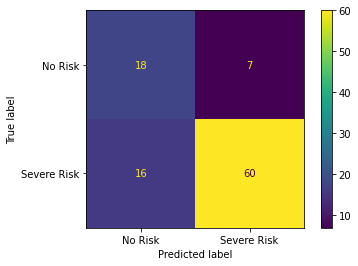

In [99]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['No Risk','Severe Risk'])
disp.plot()
plt.grid(False)
plt.show()

In [100]:
print(classification_report(raw_datasets['test']['label'], test_inx))

              precision    recall  f1-score   support

           0       0.53      0.72      0.61        25
           1       0.90      0.79      0.84        76

    accuracy                           0.77       101
   macro avg       0.71      0.75      0.72       101
weighted avg       0.80      0.77      0.78       101



### Error Analysis

In [101]:
f"suicide_risk_model_preediction/checkpoint-150"

'suicide_risk_model_preediction/checkpoint-150'

In [102]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [103]:
from torch.nn.functional import cross_entropy
def forward_pass_with_custom_model(batch):
    #place all input tensors on the device 
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    #call the model
    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"].to(device) , attention_mask=inputs["attention_mask"].to(device), labels=batch["label"].to(device))
        #get the logits
        logits = outputs.logits
        pred_labels = logits.argmax(-1)
        loss = cross_entropy(logits, batch["label"].to(device), reduction="none") #shape of logits is (batch_size, num_labels) and shape of batch["label"] is (batch_size)
        #place the outputs on the CPU for compatibility with the other dataset columns  
        return {"pred_labels": pred_labels.cpu().numpy(),"batch_loss": loss.cpu().numpy() }

In [104]:
#convert dataset to pytocrch tensors
tokenized_dataset.set_format("torch", columns=["input_ids","attention_mask" ,"label"])
#Compute loss values
tokenized_dataset["test"] = tokenized_dataset["test"].map(forward_pass_with_custom_model, batched=True, batch_size=16)

  0%|          | 0/7 [00:00<?, ?ba/s]

In [105]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'label', 'sent1', 'sent2', 'sent3', 'input_ids', 'attention_mask'],
        num_rows: 386
    })
    test: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'label', 'sent1', 'sent2', 'sent3', 'input_ids', 'attention_mask', 'pred_labels', 'batch_loss'],
        num_rows: 101
    })
})

In [106]:
index2tag = {0:'low_risk',1:'high_risk'}

In [107]:
tokenized_dataset.set_format("pandas")
cols = ["sent1","sent2","label","pred_labels","batch_loss"]
df_test= tokenized_dataset["test"][:][cols]
df_test['label'] = df_test["label"].map(index2tag)
df_test['pred_labels']=df_test['pred_labels'].map(index2tag)

In [108]:
df_test.head()

,sent1,sent2,label,pred_labels,batch_loss
0,haven felt years jsut deal anymore absolutely closest friend doesn anymore thinks boyfriend cheating methe guy doesn talk anymore dfucking boring crazy nt nt care knowi iti die nt anymore wash oit wine liquor cover smile donei ca nt anymore,-100,high_risk,high_risk,0.005329
1,months cousin told doesn live anymore made pact birthday happy kill birthday tomorrow ve thing stayed night talking nights texted week sitting van rope ready girlfriend contacted goodbye message scared person talk talk managed home sleep ringing dad ringing suicide line rang speak cliff area days ago sat hours contemplating jumping sat person change mind doesn feel change mind ve begged doctors faith ve begged speak dad scared losing scared turning family upside scared break uncle aunties heart terrified live guilt hope doesn guess needed speak mind strangers,-100,high_risk,low_risk,3.402844
2,past months ve talking guy school ve talked lot time hinting depression night told contemplating suicide cut wrists told counselor school convinced put thinking suicide side time frightened don ve dependency issues feels built tough outer shell horrible thing past ve year call school acts happy convincingly make worse helping,-100,low_risk,high_risk,3.726469
3,thought killing week years decide hurting family truely feel life useless piece shit make love happy works die kill stones longer,-100,high_risk,high_risk,0.008257
4,start trained crisis suicide intervention tricks trade people jackass skip formalities write thoughts people intervention steps urgent danger plan haven items intent kill share emerging suicidal thoughts stranger doesn good stuff pathetic piece shit unreal don deserve live killed world place bet parents sister cry bit pretty fast brother show funeral boyfriend sad find deserves mention big piece shit suicide outlet action plan frequent ve decided pills park worry fragile person find dead traumatized life don family members find drive mother chemo brother sister swear didn cancer dead kill fucked don fool thinking care mother good person nope total piece shit don deserve happiness don deserve deserve die pissed kill horrible car accident happened wasn fault killed didn horribly traumatize driver car pretty didn post wrong place,-100,high_risk,high_risk,0.006851


In [109]:
df_test.query('label!=pred_labels').head()

,sent1,sent2,label,pred_labels,batch_loss
1,months cousin told doesn live anymore made pact birthday happy kill birthday tomorrow ve thing stayed night talking nights texted week sitting van rope ready girlfriend contacted goodbye message scared person talk talk managed home sleep ringing dad ringing suicide line rang speak cliff area days ago sat hours contemplating jumping sat person change mind doesn feel change mind ve begged doctors faith ve begged speak dad scared losing scared turning family upside scared break uncle aunties heart terrified live guilt hope doesn guess needed speak mind strangers,-100,high_risk,low_risk,3.402844
2,past months ve talking guy school ve talked lot time hinting depression night told contemplating suicide cut wrists told counselor school convinced put thinking suicide side time frightened don ve dependency issues feels built tough outer shell horrible thing past ve year call school acts happy convincingly make worse helping,-100,low_risk,high_risk,3.726469
13,struggle cry chest pain constant day write sleep accomplish focus relax barely school night struggle pain fall asleep hoping won wake feel trapped circumstances convinced don deserve aching deal feeling hopeless physical pain stop living,-100,low_risk,high_risk,5.026658
24,cut time days ago haven forget shit happened person kind eating point feel worthless utterly demoralized feel idiotic move time feel answers shit piling ends back person calling feel lead bullshit don kind advice figure missing ve locked inside room days feel immobilized friends thought cared heartbreaking edit calling person back time ll hope house tonight watch ball drop step direction won shit mind totally,-100,low_risk,high_risk,5.203388
26,person college roommate ate bottle sominex home event school decided give counter pills bunch believed wasn die calling retrospect realized pills couldn hands stronger dropped end semester room cheap boarding house edge campus talked person moving house thought alternative living parents house nearby incapable dealing human emotion couple months living childhood savings account friend named person dropout point decided move west talked person coming settled bedroom apartment person bed person settled permanent spot sleeping couch didn surprise knew person lowest esteem called friend person found work city terrible work sitting bulletproof booth night gas station threatened spat psycho customers year working college town person person respective things west talked phone lot person lost wandering situation situation made things worse gas station gigs october word person play concert tour river person person town drove person beat car back college town friends give ride concert person wrecked car night supposed leave stranded person tickets money person rescue made couple hundred bucks bought person amtrak tickets back west follow car fixed promised pay back train station night left person sat hard plastic shell chairs corner terminal laughed butts telling stories shooting breeze wonderful starting person ease wasn realized made decision die felt huge weight shoulders person town train back parents house night oct drove car park played boy shot head call early head ringing person fabulous hour concert night ingested person couch pillow blanket futile effort find person hold head didn hurt person answered phone person mom matter factly informing suicide return personal possessions forget hammer shot astonishment realizing time life wrong late fix remember stumbling apartment walking blocks neighborhood bodega buy needed walked store owner immediately started yelling didn understand language didn brain wasn processing sound voice message outstretched index finger turned leave bloody footprints floor realized left apartment barefoot stepped sharp point felt thing shame apologize owner pointing door yelling sad october understanding remember anniversary person suicide coming years recently date thinking poor person time past year reali

In [110]:
df_test.query("label=='Moderate Risk'")

,sent1,sent2,label,pred_labels,batch_loss


In [111]:
df_test.query("label=='Severe Risk' & pred_labels=='Moderate Risk'")

,sent1,sent2,label,pred_labels,batch_loss
